# Antet

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from collections import Counter
from scipy import stats
from scipy.stats import chi2_contingency, fisher_exact
from scipy.cluster.hierarchy import dendrogram, linkage
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D

# --- START: Additions for Dissertation Consistency & Apple Inspiration ---

# Define the 'Trustworthy Teals' palette
# We'll use a subtle version of the colors for the wedge borders
teal_palette = ["#B2EBF2", "#00BCD4", "#00838F"]
# Set the seaborn style for a modern look
sns.set_style('whitegrid')
# Set font to Charter serif for a more academic, dissertation-appropriate look
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Charter', 'Bitstream Charter', 'Palatino Linotype', 'Times New Roman']


# --- END: Additions ---


# Load Data

In [3]:
df = pd.read_csv('anonim-clean.csv')

# Preprocessing
imaging_characteristics = ['eroziuni', 'tasări', 'edem', 'colecții', 'stenoză', 'amprentare_medulară', 
                         'osteofite', 'deshidratări_discale', 'gadolinofilie', 'iodofilie', 'hdl', 
                         'hemangioame', 'abces', 'fracturi', 'anterolistezis', 'cardiomegalie']

# Create binary columns for each imaging characteristic
for char in imaging_characteristics:
    df[char] = df['caracteristici imagistice'].str.contains(char, case=False, na=False).astype(int)

# Create a binary column for treatment type
df['treatment_type'] = np.where(df['tratament'].str.contains('chirurgical', case=False, na=False), 
                               'Chirurgical', 'Conservativ')

# Analiza descriptivă a cohortei de pacienți

In [4]:
# Vârstă
age_stats = df['vârstă'].describe()
# print("Age Statistics:")
# print(age_stats)

In [5]:
# Distribuția pe genuri
gender_counts = df['gen'].value_counts()
# print("\nDistribuția pe Gen:")
# print(gender_counts)

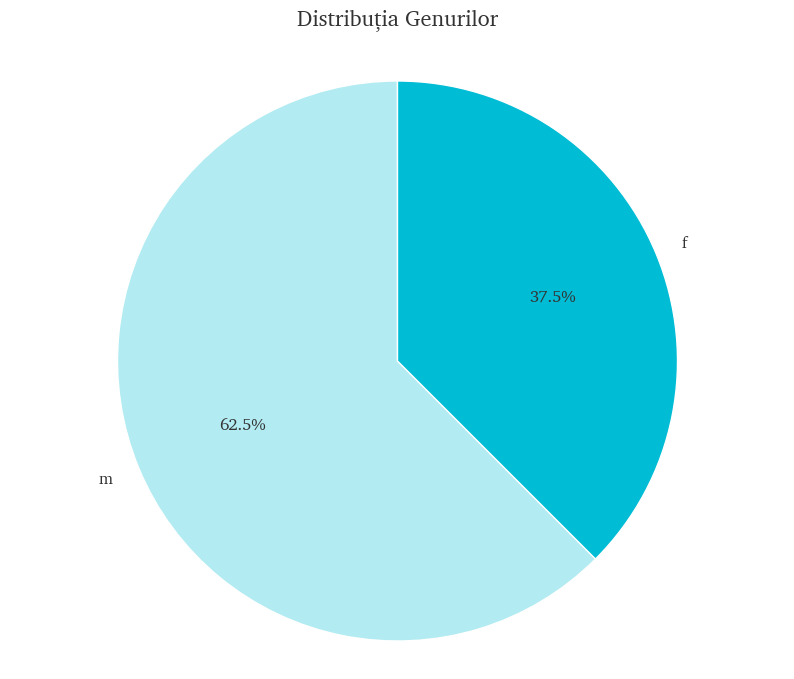

In [6]:
# #  Pie chart pentru distribuția genurilor 
# plt.figure(figsize=(8, 8))
# gender_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
# plt.title('Distribuția Genurilor')
# plt.axis('equal')
# plt.savefig('gen-freq.png')
# plt.show()


# Create the pie chart
plt.figure(figsize=(10, 8))
gender_counts.plot(
    kind='pie',
    colors=['#B2EBF2', '#00BCD4', '#00838F'],  # Directly use the colors here
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 12, 'color': '#333333', 'family': 'serif'},
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
    shadow=False
)

# Customize the title with a professional look
plt.title('Distribuția Genurilor', fontsize=16, fontweight='medium', pad=20, color='#333333', family='serif')
plt.axis('equal')

# Remove the y-label (which is auto-added by pandas)
plt.ylabel('')

# Add a subtle border to the figure
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Save with high DPI for better quality
plt.savefig('gen-freq.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


In [7]:
# Frecvențele modalităților imagistice
imaging_modalities = df['metodă imagistică'].str.split(', ', expand=True).stack().value_counts()
# print("\nImaging Modality Frequency:")
# print(imaging_modalities)

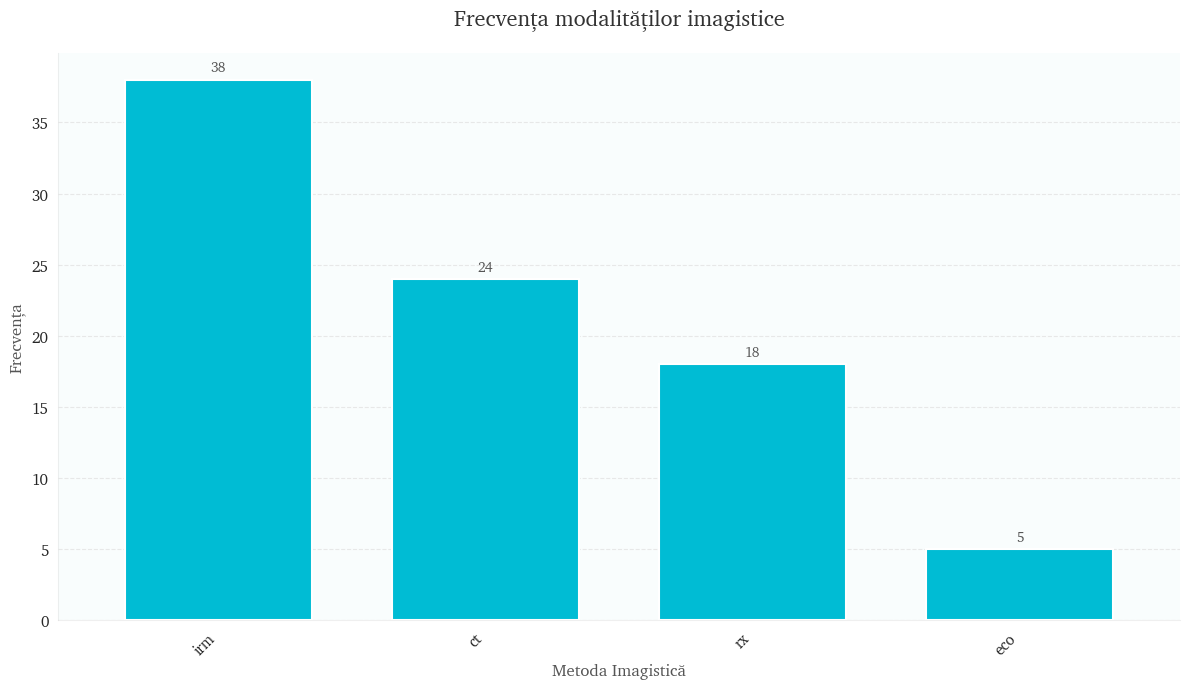

In [8]:
# # Bar chart pentru distribuția modalităților imagistice
# plt.figure(figsize=(10, 6))
# imaging_modalities.plot(kind='bar')
# plt.title('Frecvența modalităților imagistice')
# plt.xlabel('Metoda Imagistică')
# plt.ylabel('Frecvența')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.savefig('img-freq.png')
# plt.show()
# Bar chart pentru distribuția modalităților imagistice
plt.figure(figsize=(12, 7))

# Create the bar chart with a gradient effect using the teal palette
ax = imaging_modalities.plot(
    kind='bar',
    color=teal_palette[1],  # Use the middle teal as the main color
    edgecolor='white',
    width=0.7,
    linewidth=1.5
)

# Add subtle grid lines only on the y-axis (Apple style is minimal)
ax.yaxis.grid(True, linestyle='--', alpha=0.7, color='#E0E0E0')
ax.xaxis.grid(False)  # No vertical grid lines

# Remove the top and right spines (Apple-style minimalism)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_alpha(0.3)  # Subtle left spine
ax.spines['bottom'].set_alpha(0.3)  # Subtle bottom spine

# Add subtle data labels on top of each bar
for i, v in enumerate(imaging_modalities):
    ax.text(
        i, 
        v + (max(imaging_modalities) * 0.01),  # Position just above the bar
        f'{v}', 
        ha='center',
        va='bottom',
        fontsize=10,
        color='#555555',
        family='serif'
    )

# Style the title and axis labels with Charter serif
plt.title('Frecvența modalităților imagistice', 
         fontsize=16, 
         fontweight='medium',  # Apple uses medium weight, not too bold
         pad=20, 
         color='#333333',
         family='serif')

plt.xlabel('Metoda Imagistică', fontsize=12, color='#555555', family='serif')
plt.ylabel('Frecvența', fontsize=12, color='#555555', family='serif')

# Add subtle padding to tick labels
plt.xticks(rotation=45, ha='right', fontsize=11, family='serif')
plt.yticks(fontsize=11, family='serif')

# Add a very subtle background color (Apple often uses very subtle backgrounds)
ax.set_facecolor('#F9FDFD')  # Very light teal tint

# Adjust layout to fit everything
plt.tight_layout()

# Save with high DPI for better quality and a white background
plt.savefig('img-freq.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

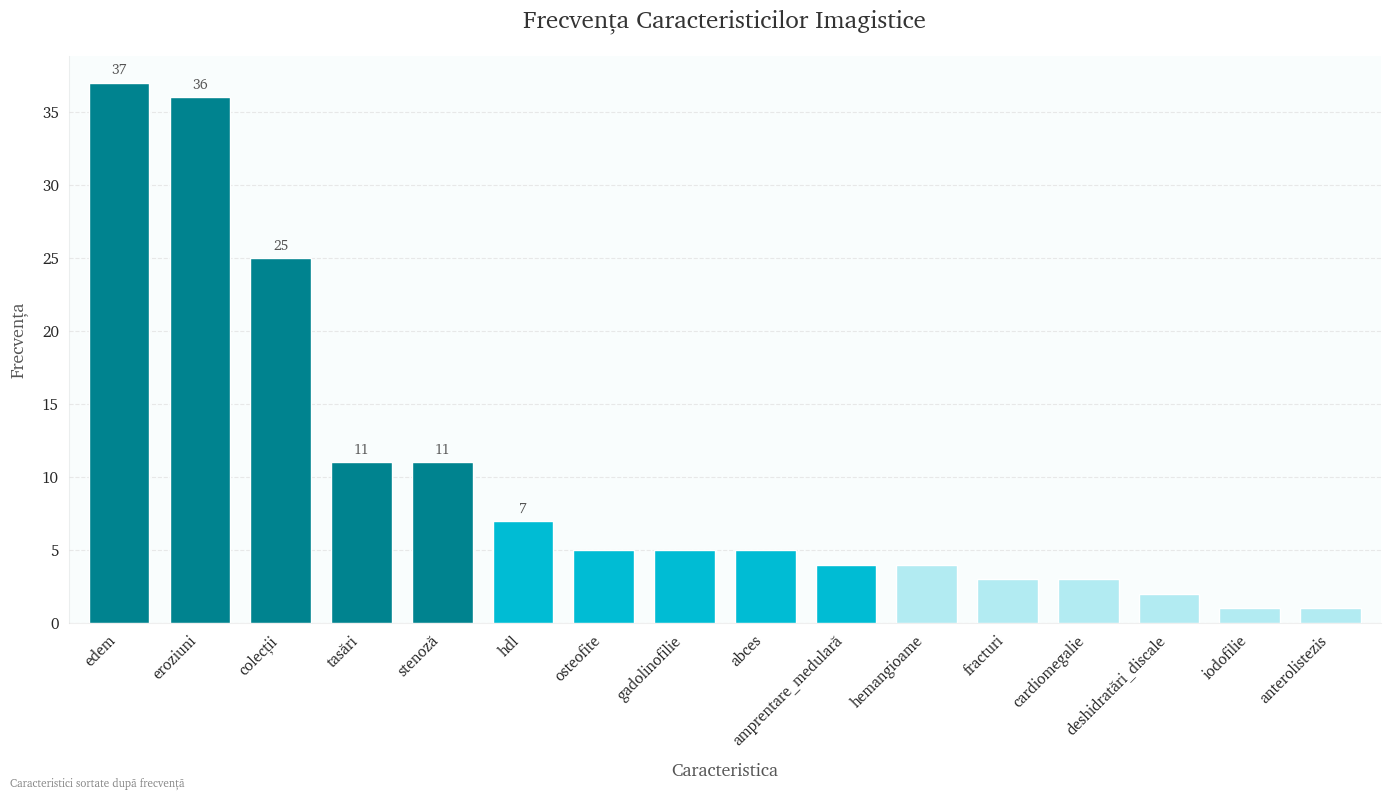

In [9]:
# # Bar Chart pentru frecvența caracteristicilor imagistice
# # Calculate and display the frequency of each characteristic
# characteristic_frequencies = df[imaging_characteristics].sum().sort_values(ascending=False)

# # Create a bar plot of characteristic frequencies
# plt.figure(figsize=(12, 6))
# characteristic_frequencies.plot(kind='bar')
# plt.title('Frecvența Caracteristicilor Imagistice')
# plt.xlabel('Caracteristica')
# plt.ylabel('Frecvența')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.savefig('freq-cara.png')
# # plt.show()


# Bar Chart pentru frecvența caracteristicilor imagistice
# Calculate and display the frequency of each characteristic
characteristic_frequencies = df[imaging_characteristics].sum().sort_values(ascending=False)

# Create a bar plot with enhanced styling
plt.figure(figsize=(14, 8))

# Create a gradient color palette based on the teal colors
# This creates a subtle gradation across bars (very Apple-like)
num_chars = len(characteristic_frequencies)
colors = []
for i in range(num_chars):
    # Use the secondary color (#00BCD4) with varying transparency
    if i < num_chars // 3:
        colors.append(teal_palette[2])  # Darkest teal for most frequent
    elif i < 2 * num_chars // 3:
        colors.append(teal_palette[1])  # Medium teal for middle frequency
    else:
        colors.append(teal_palette[0])  # Lightest teal for least frequent

# Create the bar chart with styling
ax = characteristic_frequencies.plot(
    kind='bar',
    color=colors,
    edgecolor='white',
    width=0.75,
    linewidth=1
)

# Add a very subtle background gradient (Apple-style)
ax.set_facecolor('#F9FDFD')  # Very light teal tint

# Remove the top and right spines (Apple-style minimalism)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_alpha(0.3)
ax.spines['bottom'].set_alpha(0.3)

# Add subtle grid lines only on the y-axis
ax.yaxis.grid(True, linestyle='--', alpha=0.7, color='#E0E0E0')
ax.xaxis.grid(False)  # No vertical grid lines

# Add subtle data labels on top of each bar for higher frequency items
for i, v in enumerate(characteristic_frequencies):
    # Only add text labels for bars with larger values to avoid clutter
    if v > characteristic_frequencies.max() * 0.15:  # Show labels only for significant values
        ax.text(
            i, 
            v + (max(characteristic_frequencies) * 0.01),
            f'{v}', 
            ha='center',
            va='bottom',
            fontsize=10,
            color='#555555',
            family='serif'
        )

# Style the title and labels with Charter serif
plt.title('Frecvența Caracteristicilor Imagistice', 
         fontsize=18, 
         fontweight='medium',
         pad=20, 
         color='#333333',
         family='serif')

plt.xlabel('Caracteristica', fontsize=13, color='#555555', family='serif', labelpad=10)
plt.ylabel('Frecvența', fontsize=13, color='#555555', family='serif', labelpad=10)

# Improve tick label styling
plt.xticks(rotation=45, ha='right', fontsize=11, family='serif')
plt.yticks(fontsize=11, family='serif')

# Add a subtle annotation in the corner (Apple often adds these explanatory notes)
plt.figtext(0.01, 0.01, 'Caracteristici sortate după frecvență', 
           fontsize=8, color='#888888', family='serif', style='italic')

# Adjust layout
plt.tight_layout()

# Save with high resolution
plt.savefig('freq-cara.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

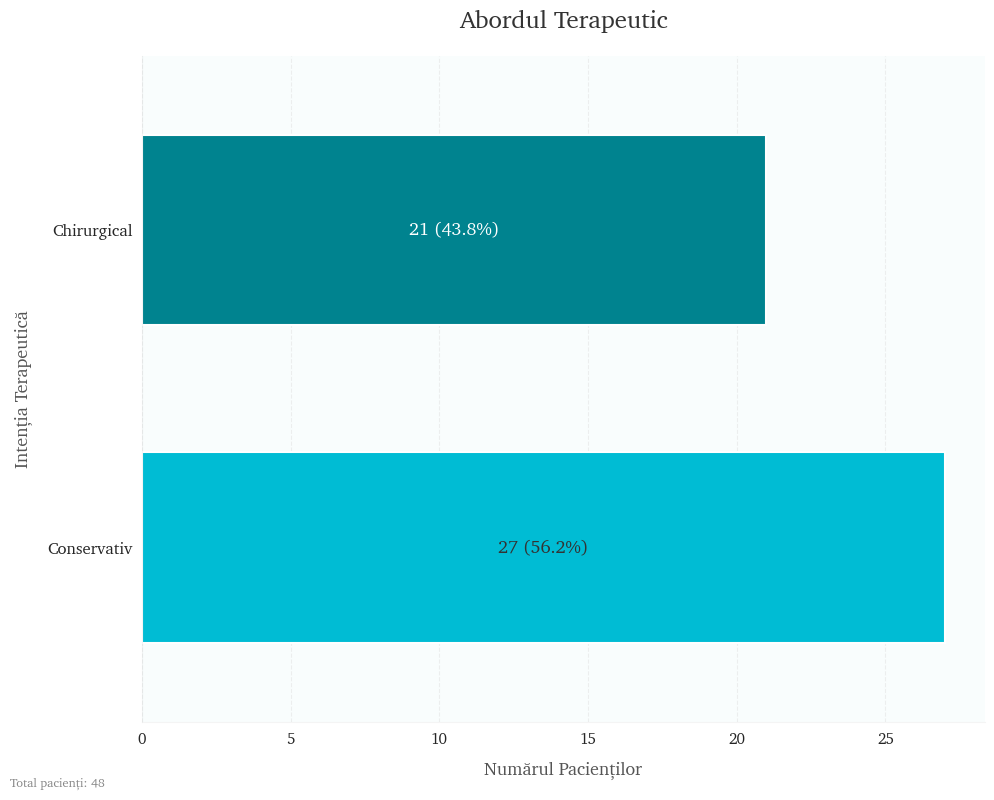

In [14]:
# Bar chart pentru abordul terapeutic
# treatment_approach = df['tratament'].str.contains('chirurgical').map({True: 'Chirurgical', False: 'Conservativ'}).value_counts()
# plt.figure(figsize=(8, 6))
# treatment_approach.plot(kind='bar')
# plt.title('Abordul terapeutic')
# plt.xlabel('Intenția terapeutică')
# plt.ylabel('Numărul Pacienților')
# plt.savefig('treat-cons-sur.png')
# plt.show()
# Bar chart pentru abordul terapeutic
treatment_approach = df['tratament'].str.contains('chirurgical').map({True: 'Chirurgical', False: 'Conservativ'}).value_counts()

# Create figure with appropriate dimensions
plt.figure(figsize=(10, 8))

# Create a horizontal bar chart (more Apple-like for binary comparisons)
ax = treatment_approach.plot(
    kind='barh',  # Horizontal bars for this binary comparison
    color=[teal_palette[1], teal_palette[2]],  # Lightest and darkest teal for clear contrast
    edgecolor='white',
    linewidth=1.5,
    width=0.6,  # Apple designs often use wider bars with spacing
)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_alpha(0.2)
ax.spines['bottom'].set_alpha(0.2)

# Add subtle grid lines only on the x-axis
ax.xaxis.grid(True, linestyle='--', alpha=0.5, color='#E0E0E0')
ax.yaxis.grid(False)
temp_label_colors = ['#333333','#FFFFFF']
# Add data labels inside the bars (Apple-style)
for i, v in enumerate(treatment_approach):
    # Position percentage and count
    ax.text(
        v/2,  # Center of bar
        i,  
        f'{v} ({(v/treatment_approach.sum()*100):.1f}%)', 
        ha='center',
        va='center',
        fontsize=13,
        color=temp_label_colors[i],  # White text for contrast
        fontweight='medium',
        family='serif'
    )

# Style the title and labels
plt.title('Abordul Terapeutic', 
         fontsize=18, 
         fontweight='medium',
         pad=20, 
         color='#333333',
         family='serif')

plt.xlabel('Numărul Pacienților', fontsize=13, color='#555555', family='serif', labelpad=10)
plt.ylabel('Intenția Terapeutică', fontsize=13, color='#555555', family='serif', labelpad=10)

# Style the tick labels
plt.xticks(fontsize=11, family='serif')
plt.yticks(fontsize=12, family='serif')

# Add a subtle background color
ax.set_facecolor('#F9FDFD')  # Very light teal tint

# Add an annotation with the total number
plt.figtext(
    0.01, 0.01, 
    f'Total pacienți: {treatment_approach.sum()}', 
    fontsize=9, 
    color='#888888', 
    family='serif', 
    style='italic'
)

# # Add a legend-like annotation explaining colors
# y_pos = 0.95
# plt.figtext(0.75, y_pos, 'Chirurgical', fontsize=10, color=teal_palette[2], family='serif')
# plt.figtext(0.75, y_pos-0.03, 'Conservativ', fontsize=10, color=teal_palette[0], family='serif')

# Adjust layout
plt.tight_layout()

# Save with high resolution
plt.savefig('treat-cons-sur.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [ ]:
# # import matplotlib.pyplot as plt
# # import matplotlib as mpl

# # Configure rcParams for an Apple-inspired minimalist style
# mpl.rcParams.update({
#     'font.family': 'Charter',      # Use the Charter font
#     'font.size': 11,               # Set base font size to 11pt
#     'figure.facecolor': 'white',   # White background for a clean look
#     'axes.edgecolor': '#d3d3d3',     # Light gray axes borders
#     'axes.linewidth': 0.8,         # Thin axes lines
#     'axes.titlesize': 14,          # Slightly larger title
#     'axes.labelsize': 11,          # Label size to match base font
#     'xtick.color': '#555555',      # Darker ticks for readability
#     'ytick.color': '#555555',
#     'grid.color': '#e6e6e6',       # Very light grid lines
#     'grid.linestyle': '-',         # Solid grid lines if you choose to display them
#     'grid.linewidth': 0.6,
#     'legend.frameon': False,       # No border around the legend
# })

# # Your data processing remains unchanged
# treatment_approach = df['tratament'].str.contains('chirurgical').map({True: 'Chirurgical', False: 'Conservator'}).value_counts()

# plt.figure(figsize=(8, 6))

# # Using colors reminiscent of Apple design: a signature blue and a complementary hue.
# treatment_approach.plot(kind='bar', color=['#007AFF', '#34C759'])

# plt.title('Abordul terapeutic')
# plt.xlabel('Intenția terapeutică')
# plt.ylabel('Numărul Pacienților')

# # Rotate labels for better readability
# plt.xticks(rotation=0)  # Change to 45 if you want a slight tilt

# # Remove the top and right spines for an extra clean, modern look
# ax = plt.gca()
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# plt.savefig('treat-cons-sur.png', bbox_inches='tight')
# plt.show()


# Analiza comorbidităților

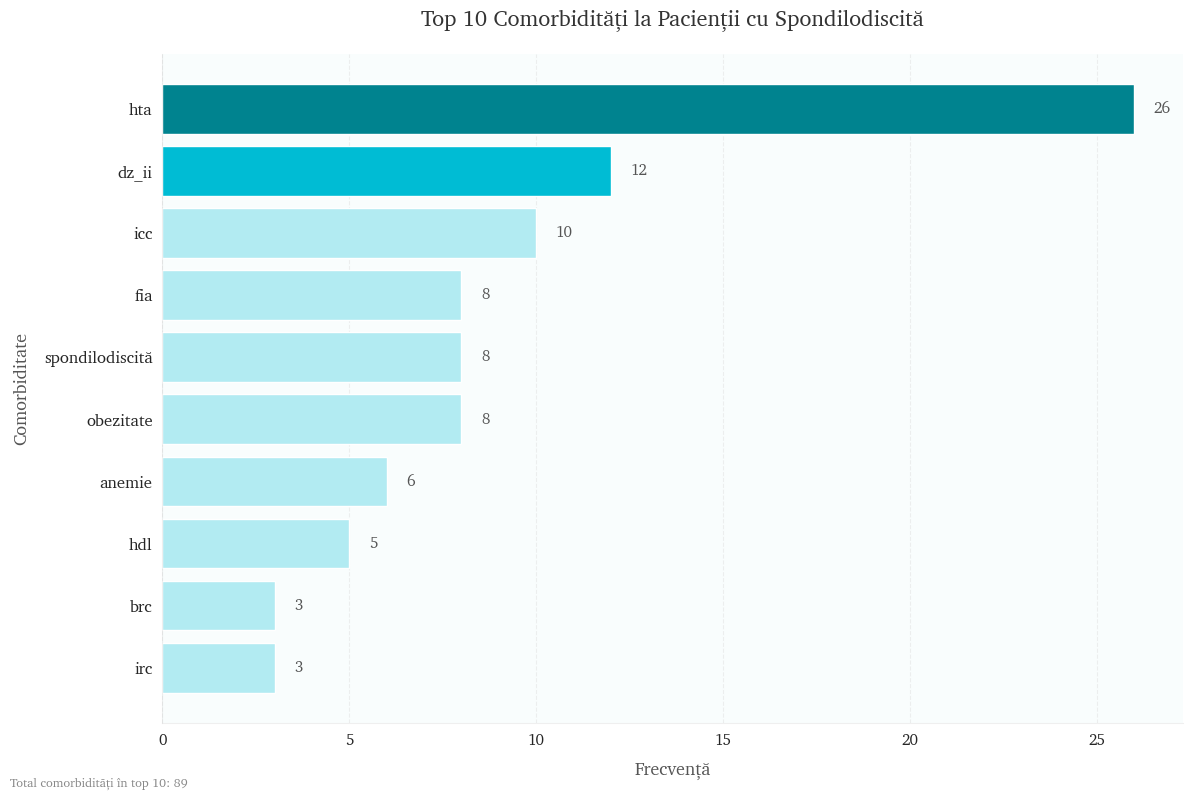

In [16]:

# # Funcție pentru a extrage comorbidități dintr-un șir de caractere
# def extract_comorbidities(s):
#     if pd.isna(s):
#         return []
#     return [c.strip() for c in s.split(',')]

# # Extragerea și numărarea comorbidităților
# all_comorbidities = []
# for app in df['app']:
#     all_comorbidities.extend(extract_comorbidities(app))

# # Numărarea frecvenței comorbidităților
# comorbidity_counts = Counter(all_comorbidities)

# # Sortarea comorbidităților după frecvență și selectarea primelor 10
# top_10_comorbidities = dict(sorted(comorbidity_counts.items(), key=lambda x: x[1], reverse=True)[:10])

# # Crearea graficului
# plt.figure(figsize=(12, 6))
# plt.bar(top_10_comorbidities.keys(), top_10_comorbidities.values())
# plt.title('Top 10 Comorbidități la Pacienții cu Spondilodiscită')
# plt.xlabel('Comorbiditate')
# plt.ylabel('Frecvență')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.savefig('top-comorbiditati.png')
# # Afișarea graficului
# plt.show()

# # Afișarea rezultatelor numerice
# # print("Top 10 Comorbidități:")
# # for comorbidity, count in top_10_comorbidities.items():
# #     print(f"{comorbidity}: {count}")


# Funcție pentru a extrage comorbidități dintr-un șir de caractere
def extract_comorbidities(s):
    if pd.isna(s):
        return []
    return [c.strip() for c in s.split(',')]

# Extragerea și numărarea comorbidităților
all_comorbidities = []
for app in df['app']:
    all_comorbidities.extend(extract_comorbidities(app))

# Numărarea frecvenței comorbidităților
comorbidity_counts = Counter(all_comorbidities)

# Sortarea comorbidităților după frecvență și selectarea primelor 10
top_10_comorbidities = dict(sorted(comorbidity_counts.items(), key=lambda x: x[1], reverse=True)[:10])

# Create a horizontal bar chart (better for displaying text labels)
plt.figure(figsize=(12, 8))

# Create gradient colors from our teal palette
# Darker teal for more frequent comorbidities, lighter for less frequent
comorbidity_values = list(top_10_comorbidities.values())
comorbidity_keys = list(top_10_comorbidities.keys())

# Sort items in descending order for horizontal bar chart (bottom to top)
comorbidity_keys.reverse()
comorbidity_values.reverse()

# Create a custom color gradient from our teal palette
max_val = max(comorbidity_values)
colors = []
for value in comorbidity_values:
    # Calculate color based on frequency
    if value > max_val * 0.8:
        color = teal_palette[2]  # Darkest teal for highest frequencies
    elif value > max_val * 0.4:
        color = teal_palette[1]  # Medium teal for middle frequencies
    else:
        color = teal_palette[0]  # Light teal for lower frequencies
    colors.append(color)

# Create the horizontal bar chart with styling
ax = plt.barh(comorbidity_keys, comorbidity_values, color=colors, edgecolor='white', linewidth=1)

# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_alpha(0.3)
ax.spines['bottom'].set_alpha(0.3)

# Add subtle grid lines only on the x-axis
ax.xaxis.grid(True, linestyle='--', alpha=0.5, color='#E0E0E0')
ax.yaxis.grid(False)

# Add data labels at the end of each bar
for i, v in enumerate(comorbidity_values):
    plt.text(
        v + max(comorbidity_values) * 0.02,  # Position just right of the bar
        i,  # y position
        str(v),  # The value
        va='center',
        ha='left',
        fontsize=11,
        color='#555555',
        family='serif'
    )

# Style the title and labels with Charter serif
plt.title('Top 10 Comorbidități la Pacienții cu Spondilodiscită', 
         fontsize=16, 
         fontweight='medium',
         pad=20, 
         color='#333333',
         family='serif')

plt.xlabel('Frecvență', fontsize=13, color='#555555', family='serif', labelpad=10)
plt.ylabel('Comorbiditate', fontsize=13, color='#555555', family='serif', labelpad=10)

# Improve y-tick label styling (comorbidity names)
plt.yticks(fontsize=12, family='serif')
plt.xticks(fontsize=11, family='serif')

# Add a subtle background color
ax.set_facecolor('#F9FDFD')  # Very light teal tint

# Add an annotation with the total
total_comorbidities = sum(comorbidity_values)
plt.figtext(
    0.01, 0.01, 
    f'Total comorbidități în top 10: {total_comorbidities}', 
    fontsize=9, 
    color='#888888', 
    family='serif', 
    style='italic'
)

# Adjust layout
plt.tight_layout()

# Save with high resolution
plt.savefig('top-comorbiditati.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Distribuția Tratamentelor pentru Toate Caracteristicile Imagistice

In [ ]:
# Claude Initialize results DataFrame with proper columns
results = pd.DataFrame(columns=['Characteristic', 'Conservativ %', 'Chirurgical %', 'p-value'])

# Analyze all characteristics
for char in imaging_characteristics:
    # Create contingency table
    contingency_table = pd.crosstab(df[char], df['treatment_type'])
    
    # Perform statistical test
    if (contingency_table.values < 5).any():
        _, p_value = fisher_exact(contingency_table)
    else:
        _, p_value, _, _ = chi2_contingency(contingency_table)
    
    # Calculate percentages - Fix: Access columns by their actual names rather than indices
    # First identify the column names (treatment types)
    treatment_types = contingency_table.columns.tolist()
    
    # Check if there's positive findings (value 1) in the characteristic
    if 1 in contingency_table.index:
        # Assuming first column (index 0) is Conservative and second column (index 1) is Surgical
        if len(treatment_types) >= 2:
            conservative_type = treatment_types[0]  # Typically 0 for Conservative
            surgical_type = treatment_types[1]      # Typically 1 for Surgical
            
            # Calculate the percentages for presence of characteristic (index value 1)
            conservative_pct = (contingency_table.loc[1, conservative_type] / contingency_table[conservative_type].sum()) * 100
            surgical_pct = (contingency_table.loc[1, surgical_type] / contingency_table[surgical_type].sum()) * 100
        else:
            # Handle case where only one treatment type exists in the data
            only_type = treatment_types[0]
            if only_type == 0:  # Conservative
                conservative_pct = (contingency_table.loc[1, only_type] / contingency_table[only_type].sum()) * 100
                surgical_pct = 0
            else:  # Surgical
                conservative_pct = 0
                surgical_pct = (contingency_table.loc[1, only_type] / contingency_table[only_type].sum()) * 100
    else:
        conservative_pct = 0
        surgical_pct = 0
    
    # Add row to results - using a safer approach to avoid FutureWarning
    new_row = {
        'Characteristic': char,
        'Conservativ %': conservative_pct,
        'Chirurgical %': surgical_pct,
        'p-value': p_value
    }
    results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)

# Sort results by the absolute difference between percentages
results['Difference'] = abs(results['Conservativ %'] - results['Chirurgical %'])
results = results.sort_values('Difference', ascending=False)

# Create combined chart for all characteristics
plt.figure(figsize=(15, 10))
x = np.arange(len(imaging_characteristics))
width = 0.35

conservativ = results['Conservativ %']
chirurgical = results['Chirurgical %']

plt.bar(x - width/2, conservativ, width, label='Conservativ', color='blue', alpha=0.5)
plt.bar(x + width/2, chirurgical, width, label='Chirurgical', color='red', alpha=0.5)
plt.xlabel('Caracteristici Imagistice')
plt.ylabel('Procentaj (%)')
plt.title('Distribuția Tratamentelor pentru Toate Caracteristicile Imagistice')
plt.xticks(x, results['Characteristic'], rotation=45, ha='right')
plt.legend()

# Add percentage values on bars
def add_value_labels(ax, spacing=5):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        label = f"{y_value:.1f}%"
        
        ax.annotate(label, (x_value, y_value), xytext=(0, spacing),
                    textcoords="offset points", ha='center', va='bottom')

add_value_labels(plt.gca())
plt.tight_layout()
plt.savefig('tratament-caracteristici.png')
plt.show()

# Display results table including difference
results['Difference'] = results['Difference'].round(2)
print(results[['Characteristic', 'Conservativ %', 'Chirurgical %', 'Difference', 'p-value']].to_string(index=False))

In [ ]:
#Grok
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the data from the contingency tables
data = {
    'Characteristic': ['eroziuni', 'colecții', 'hdl'],
    'Conservativ %': [74.1, 44.4, 11.1],
    'Chirurgical %': [76.2, 61.9, 19.0],
    'p-value': [1.0000, 0.2592, 0.6830]
}

# Create a DataFrame
results = pd.DataFrame(data)

# Calculate the absolute difference between percentages
results['Difference'] = abs(results['Conservativ %'] - results['Chirurgical %'])

# Sort by difference in descending order
results = results.sort_values('Difference', ascending=False)

# Create the bar plot
plt.figure(figsize=(15, 10))
x = np.arange(len(results))
width = 0.35

# Plot bars for Conservative and Surgical groups
plt.bar(x - width/2, results['Conservativ %'], width, label='Conservativ', color='blue', alpha=0.5)
plt.bar(x + width/2, results['Chirurgical %'], width, label='Chirurgical', color='red', alpha=0.5)

# Customize the plot
plt.xlabel('Caracteristici Imagistice')
plt.ylabel('Procentaj (%)')
plt.title('Distribuția Tratamentelor pentru Caracteristicile Imagistice')
plt.xticks(x, results['Characteristic'], rotation=45, ha='right')
plt.legend()

# Add percentage labels above the bars
for i in range(len(x)):
    plt.text(x[i] - width/2, results['Conservativ %'].iloc[i] + 2, 
             f"{results['Conservativ %'].iloc[i]:.1f}%", ha='center', va='bottom')
    plt.text(x[i] + width/2, results['Chirurgical %'].iloc[i] + 2, 
             f"{results['Chirurgical %'].iloc[i]:.1f}%", ha='center', va='bottom')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print the results table
print("\nResults Table:")
print(results[['Characteristic', 'Conservativ %', 'Chirurgical %', 'Difference', 'p-value']]
      .to_string(index=False, float_format='%.1f', col_space=12))


Caracteristica: eroziuni
Tabel de contingență:
          Non-chirurgical  Chirurgical
Absenta                 7            5
Prezenta               20           16
Valoare p: 1.0000
% în grupul non-chirurgical: 74.1%
% în grupul chirurgical: 76.2%

Caracteristica: tasări
Tabel de contingență:
          Non-chirurgical  Chirurgical
Absenta                21           16
Prezenta                6            5
Valoare p: 1.0000
% în grupul non-chirurgical: 22.2%
% în grupul chirurgical: 23.8%

Caracteristica: edem
Tabel de contingență:
          Non-chirurgical  Chirurgical
Absenta                 6            5
Prezenta               21           16
Valoare p: 1.0000
% în grupul non-chirurgical: 77.8%
% în grupul chirurgical: 76.2%

Caracteristica: colecții
Tabel de contingență:
          Non-chirurgical  Chirurgical
Absenta                15            8
Prezenta               12           13
Valoare p: 0.2592
% în grupul non-chirurgical: 44.4%
% în grupul chirurgical: 61.9%

Caracteri

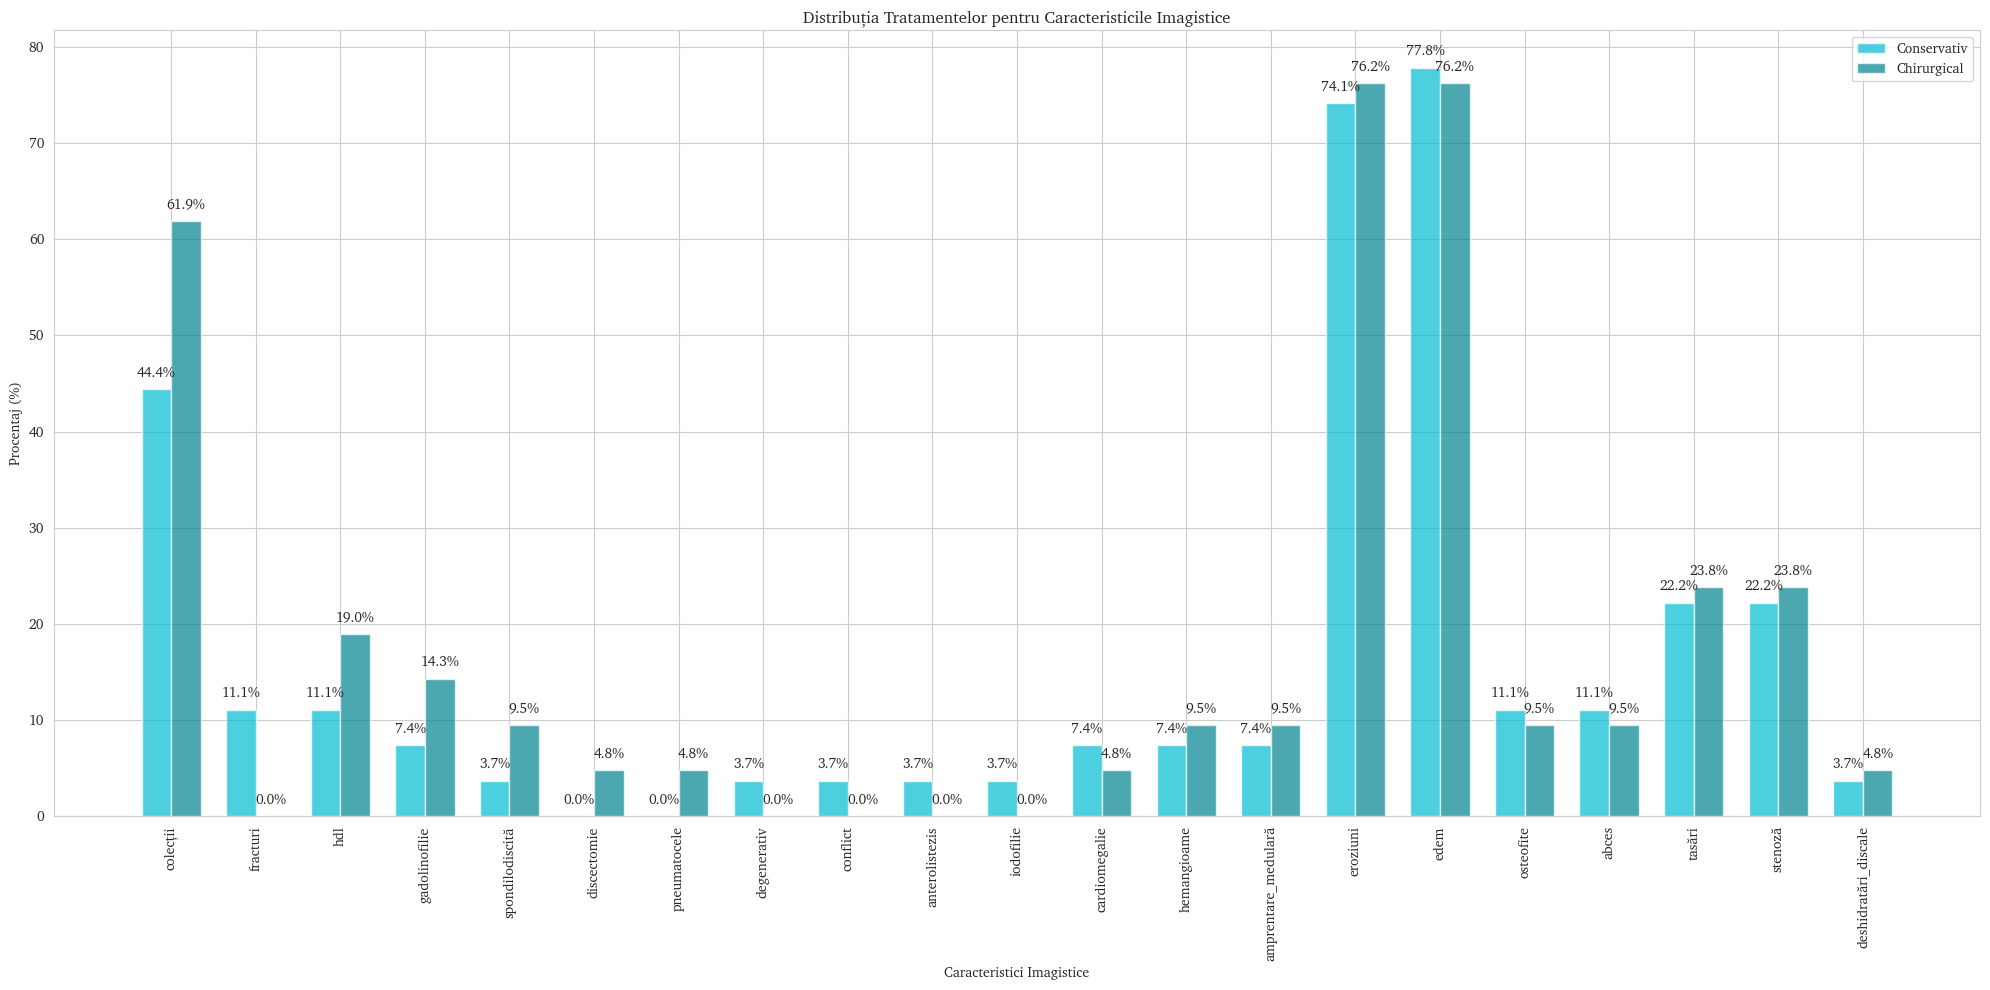

In [22]:
#Grok Toate
#  import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# import seaborn as sns
# from scipy.stats import fisher_exact

# --- Jupyter Notebook Header Settings ---
# Define the 'Trustworthy Teals' palette
teal_palette = ["#B2EBF2", "#00BCD4", "#00838F"]
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Charter', 'Bitstream Charter', 'Palatino Linotype', 'Times New Roman']

# Assuming df is loaded from your CSV
# Example: df = pd.read_csv('anonim-clean.csv')

# Step 1: Extract unique characteristics from 'caracteristici imagistice'
unique_characteristics = df['caracteristici imagistice'].dropna().str.split(',').explode().str.strip().unique()

# Step 2: Function to check for characteristic presence
def has_characteristic(char, text):
    if pd.isna(text):
        return 0
    characteristics = [c.strip() for c in text.split(',')]
    return 1 if char in characteristics else 0

# Step 3: Create binary columns for each characteristic
for char in unique_characteristics:
    df[char] = df['caracteristici imagistice'].apply(lambda x: has_characteristic(char, x))

# Step 4: Ensure treatment_type is binary (0=Conservator, 1=Chirurgical)
df['treatment_type_binary'] = df['tratament'].str.contains('chirurgical', case=False, na=False).astype(int)

# Step 5: Analyze all characteristics and store results
results = []
for char in unique_characteristics:
    # Create contingency table
    contingency_table = pd.crosstab(df[char], df['treatment_type_binary'])
    contingency_table.index = ['Absenta', 'Prezenta']
    contingency_table.columns = ['Non-chirurgical', 'Chirurgical']
    
    # Perform Fisher's exact test (handle non-2x2 tables gracefully)
    if contingency_table.shape == (2, 2):
        odds_ratio, p_value = fisher_exact(contingency_table)
    else:
        p_value = np.nan  # Indicate test not applicable
    
    # Calculate percentages
    total_patients = len(df)
    total_with_char = contingency_table.loc['Prezenta'].sum() if 'Prezenta' in contingency_table.index else 0
    pct_conservative = (contingency_table.loc['Prezenta', 'Non-chirurgical'] / contingency_table['Non-chirurgical'].sum()) * 100 if contingency_table['Non-chirurgical'].sum() > 0 else 0
    pct_surgical = (contingency_table.loc['Prezenta', 'Chirurgical'] / contingency_table['Chirurgical'].sum()) * 100 if contingency_table['Chirurgical'].sum() > 0 else 0
    difference = abs(pct_conservative - pct_surgical)
    
    # Store results
    results.append({
        'Characteristic': char,
        'Conservativ %': pct_conservative,
        'Chirurgical %': pct_surgical,
        'Difference': difference,
        'p-value': p_value
    })
    
    # Print contingency table and p-value
    print(f"\nCaracteristica: {char}")
    print("Tabel de contingență:")
    print(contingency_table)
    print(f"Valoare p: {p_value:.4f}" if not np.isnan(p_value) else "Valoare p: N/A")
    print(f"% în grupul non-chirurgical: {pct_conservative:.1f}%")
    print(f"% în grupul chirurgical: {pct_surgical:.1f}%")

# Step 6: Convert results to DataFrame and sort by difference
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Difference', ascending=False)

# Step 7: Format results for printing
results_df['Conservativ %'] = results_df['Conservativ %'].round(1)
results_df['Chirurgical %'] = results_df['Chirurgical %'].round(1)
results_df['Difference'] = results_df['Difference'].round(1)
results_df['p-value'] = results_df['p-value'].apply(lambda x: f"{x:.4f}" if not np.isnan(x) else "N/A")

# Print results table
print("\nRezultate finale:")
print(results_df.to_string(index=False))

# Step 8: Create bar plot
plt.figure(figsize=(20, 10))
x = np.arange(len(results_df))
width = 0.35

plt.bar(x - width/2, results_df['Conservativ %'], width, label='Conservativ', color=teal_palette[1], alpha=0.7)
plt.bar(x + width/2, results_df['Chirurgical %'], width, label='Chirurgical', color=teal_palette[2], alpha=0.7)

# Add percentage labels
for i, v in enumerate(results_df['Conservativ %']):
    plt.text(i - width/2, v + 1, f"{v:.1f}%", ha='center', va='bottom', fontsize=10)
for i, v in enumerate(results_df['Chirurgical %']):
    plt.text(i + width/2, v + 1, f"{v:.1f}%", ha='center', va='bottom', fontsize=10)

# Customize plot
plt.xticks(x, results_df['Characteristic'], rotation=90)
plt.xlabel('Caracteristici Imagistice')
plt.ylabel('Procentaj (%)')
plt.title('Distribuția Tratamentelor pentru Caracteristicile Imagistice')
plt.legend()
plt.tight_layout()

# Save the plot 
plt.savefig('tratament-caracteristici.png')
plt.show()

# Tabele de contingență FICHER V2

In [18]:
# Assuming df is your DataFrame with 48 patients and binary characteristic columns ('eroziuni', 'colecții', 'hdl')
# And a binary treatment column (e.g., df['is_surgical'] = df['tratament'].str.contains('chirurgical'))

characteristics_to_analyze = ['eroziuni', 'colecții', 'hdl'] # The 3 characteristics chosen

# Ensure treatment_type is binary 0/1 for crosstab (0=Conservator, 1=Chirurgical)
df['treatment_type_binary'] = df['tratament'].str.contains('chirurgical', case=False, na=False).astype(int)

for char in characteristics_to_analyze:
    # Create contingency table for this characteristic based on unique patients (df)
    # Index: Presence (0/1), Columns: Treatment Type (0/1)
    contingency_table_correct = pd.crosstab(df[char], df['treatment_type_binary'])

    # Rename index and columns for clarity in output/table text
    contingency_table_correct.index = ['Absenta', 'Prezenta']
    contingency_table_correct.columns = ['Non-chirurgical', 'Chirurgical']

    print(f"Caracteristica: {char}")
    print(f"Tabel de contingență (corect):")
    print(contingency_table_correct)

    # Perform Fisher's exact test on the correct contingency table
    # fisher_exact returns oddsratio and pvalue
    odds_ratio, p_value_correct = fisher_exact(contingency_table_correct)

    print(f"Valoare p (corect): {p_value_correct:.4f}\n")

    # Optional: Calculate percentages out of total patients (N=48)
    total_patients = len(df)
    if 'Prezenta' in contingency_table_correct.index:
        total_with_char = contingency_table_correct.loc['Prezenta'].sum()
        pct_with_char = (total_with_char / total_patients) * 100
        print(f"Total pacienți cu {char}: {total_with_char} ({pct_with_char:.1f}%)")
        
        # Optional: Percentages within treatment groups (as in your Figure 19)
        if 'Non-chirurgical' in contingency_table_correct.columns and 'Chirurgical' in contingency_table_correct.columns:
             if contingency_table_correct['Non-chirurgical'].sum() > 0:
                 pct_conservative_with_char = (contingency_table_correct.loc['Prezenta', 'Non-chirurgical'] / contingency_table_correct['Non-chirurgical'].sum()) * 100
             else:
                 pct_conservative_with_char = 0
                 
             if contingency_table_correct['Chirurgical'].sum() > 0:
                 pct_surgical_with_char = (contingency_table_correct.loc['Prezenta', 'Chirurgical'] / contingency_table_correct['Chirurgical'].sum()) * 100
             else:
                 pct_surgical_with_char = 0
             print(f"% în grupul non-chirurgical cu {char}: {pct_conservative_with_char:.1f}%")
             print(f"% în grupul chirurgical cu {char}: {pct_surgical_with_char:.1f}%\n")

Caracteristica: eroziuni
Tabel de contingență (corect):
          Non-chirurgical  Chirurgical
Absenta                 7            5
Prezenta               20           16
Valoare p (corect): 1.0000

Total pacienți cu eroziuni: 36 (75.0%)
% în grupul non-chirurgical cu eroziuni: 74.1%
% în grupul chirurgical cu eroziuni: 76.2%

Caracteristica: colecții
Tabel de contingență (corect):
          Non-chirurgical  Chirurgical
Absenta                15            8
Prezenta               12           13
Valoare p (corect): 0.2592

Total pacienți cu colecții: 25 (52.1%)
% în grupul non-chirurgical cu colecții: 44.4%
% în grupul chirurgical cu colecții: 61.9%

Caracteristica: hdl
Tabel de contingență (corect):
          Non-chirurgical  Chirurgical
Absenta                24           17
Prezenta                3            4
Valoare p (corect): 0.6830

Total pacienți cu hdl: 7 (14.6%)
% în grupul non-chirurgical cu hdl: 11.1%
% în grupul chirurgical cu hdl: 19.0%



# Media investigațiilor per comorbiditate

In [ ]:

# Citirea datelor
# df = pd.read_csv('anonim-clean.csv')

# Funcție pentru a extrage comorbidități și investigații
def extract_items(s):
    if pd.isna(s):
        return []
    return [c.strip() for c in s.split(',')]

# Extragerea comorbidităților și investigațiilor
df['comorbidities'] = df['app'].apply(extract_items)
df['investigations'] = df['metodă imagistică'].apply(extract_items)

# Numărarea investigațiilor pentru fiecare pacient
df['num_investigations'] = df['investigations'].apply(len)

# Selectarea celor mai comune 5 comorbidități
all_comorbidities = [item for sublist in df['comorbidities'] for item in sublist]
top_5_comorbidities = [x[0] for x in Counter(all_comorbidities).most_common(5)]

# Crearea variabilelor dummy pentru top 5 comorbidități
for comorbidity in top_5_comorbidities:
    df[f'has_{comorbidity}'] = df['comorbidities'].apply(lambda x: comorbidity in x).astype(int)

# Analiză descriptivă
plt.figure(figsize=(12, 6))
df.boxplot(column='num_investigations', by=[f'has_{c}' for c in top_5_comorbidities])
plt.title('Distribuția numărului de investigații per comorbiditate')
plt.suptitle('')
plt.ylabel('Număr de investigații')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calcularea și afișarea mediei investigațiilor pentru fiecare comorbiditate
print("Media investigațiilor per comorbiditate:")
for comorbidity in top_5_comorbidities:
    mean_investigations = df[df[f'has_{comorbidity}'] == 1]['num_investigations'].mean()
    print(f"{comorbidity}: {mean_investigations:.2f}")

# # Pregătirea datelor pentru regresia Poisson
# X = df[[f'has_{c}' for c in top_5_comorbidities]]
# y = df['num_investigations']

# # Adăugarea unei constante la predictori
# X = sm.add_constant(X)

# # Regresia Poisson
# poisson_model = poisson('num_investigations ~ ' + ' + '.join([f'has_{c}' for c in top_5_comorbidities]), data=df).fit()

# # Afișarea rezultatelor regresiei
# print("\nRezultatele regresiei Poisson:")
# print(poisson_model.summary())

# # Interpretarea coeficienților
# print("\nInterpretarea coeficienților (creșterea procentuală a numărului de investigații):")
# for comorbidity in top_5_comorbidities:
#     coef = poisson_model.params[f'has_{comorbidity}']
#     increase = (np.exp(coef) - 1) * 100
#     p_value = poisson_model.pvalues[f'has_{comorbidity}']
#     print(f"{comorbidity}: {increase:.2f}% (p-value: {p_value:.4f})")

# Regresie liniară: Comorbidități vs Investigații imagistice 


Coeficientul de corelație Pearson între comorbidități și investigații: 0.163
                            OLS Regression Results                            
Dep. Variable:        nr_investigatii   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.257
Date:                Sun, 04 May 2025   Prob (F-statistic):              0.268
Time:                        08:36:04   Log-Likelihood:                -59.522
No. Observations:                  48   AIC:                             123.0
Df Residuals:                      46   BIC:                             126.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

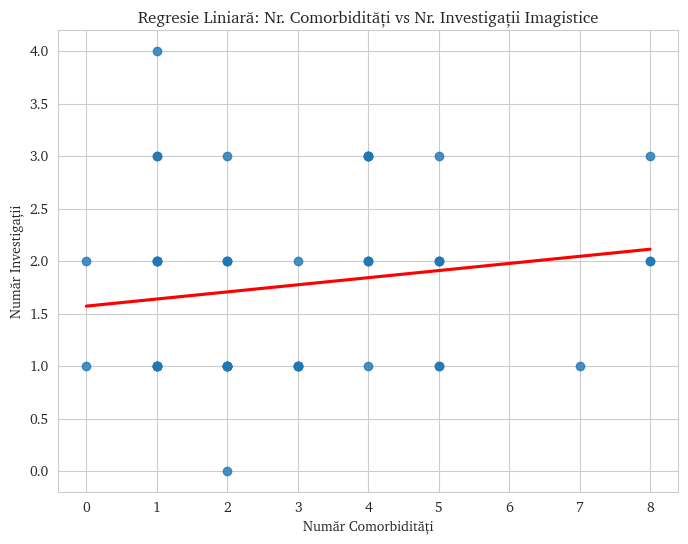

In [23]:
# --- Calcul coloane suplimentare pentru regresie: comorbidități și investigații ---

# Dacă coloana 'app' conține comorbidități separate prin virgulă
df['nr_comorbiditati'] = df['app'].fillna('').apply(lambda x: len(x.split(',')) if x.strip() else 0)

# Dacă coloana 'metodă imagistică' conține metode separate prin virgulă
df['nr_investigatii'] = df['metodă imagistică'].fillna('').apply(lambda x: len(x.split(',')) if x.strip() else 0)

# --- Regresie liniară: Comorbidități vs Investigații imagistice ---

import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# Calculăm coeficientul de corelație Pearson
correlatie = df[['nr_comorbiditati', 'nr_investigatii']].corr().iloc[0, 1]
print(f"Coeficientul de corelație Pearson între comorbidități și investigații: {correlatie:.3f}")

# Definim variabilele
X = df['nr_comorbiditati']
y = df['nr_investigatii']
X_const = sm.add_constant(X)  # Adăugăm termenul liber

# Antrenăm modelul de regresie liniară
model = sm.OLS(y, X_const).fit()
print(model.summary())

# Vizualizare: scatter plot + linie de regresie
plt.figure(figsize=(8, 6))
sns.regplot(x='nr_comorbiditati', y='nr_investigatii', data=df, ci=None, line_kws={'color': 'red'})
plt.title("Regresie Liniară: Nr. Comorbidități vs Nr. Investigații Imagistice")
plt.xlabel("Număr Comorbidități")
plt.ylabel("Număr Investigații")
plt.grid(True)
plt.show()


# Corelație Spearman

In [ ]:
from scipy.stats import spearmanr

# Asigură-te că valorile lipsă sunt tratate (dar deja ar trebui din calculele anterioare)
# Calculează corelația Spearman
spearman_corr, spearman_p = spearmanr(df['nr_comorbiditati'], df['nr_investigatii'])

# Afișează rezultatul
print(f"Coeficientul Spearman: {spearman_corr:.3f}")
print(f"Valoarea p (semnificație statistică): {spearman_p:.3f}")
